In [ ]:
import keras
import numpy as np
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)

from artificial_gps.settings import (
    INPUT_SEQUENCE_LEN,
    INPUT_DATA_COLUMNS,
    OUTPUT_DATA_COLUMNS
)


In [ ]:
force_cpu_run = True
if force_cpu_run:
    tf.config.set_visible_devices([], 'GPU')

# print(INPUT_DATA_COLUMNS)
# print(OUTPUT_DATA_COLUMNS)
def create_model() -> Model:
    """
    Creates dl model
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(len(INPUT_DATA_COLUMNS)))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(len(OUTPUT_DATA_COLUMNS)))

    optimizer = optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

In [ ]:
from artificial_gps.data import load_preprocessed_dataset
train_x, train_y, dev_x, dev_y, test_x, test_y, scaler_x, scaler_y = load_preprocessed_dataset(INPUT_DATA_COLUMNS,OUTPUT_DATA_COLUMNS )

In [ ]:
model = create_model()

history = model.fit(train_x,
                    train_y,
                    epochs=30,
                    batch_size=64,
                    validation_data=(dev_x, dev_y))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])

plt.plot(history.history["val_loss"])

In [ ]:
scaler_y.inverse_transform(model.predict(dev_x))


In [ ]:
scaler_y = inverse_transform(dev_y)


In [ ]:
test_y[180:200]

In [ ]:
from artificial_gps.data import load_dataset
train_x, train_y, dev_x, dev_y, test_x, test_y = load_dataset()
import matplotlib.pyplot as plt

plt.hist(train_y[:200, 0], 10000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from artificial_gps.data import load_sequences

x_df, y_df = load_sequences()


In [ ]:
print(y_df.describe())
print(y_df.shape)
# removes outlayers

y_df = y_df[(np.abs(stats.zscore(y_df)) < 3).all(axis=1)]
print(y_df.describe())
print(y_df.shape)


In [ ]:
y_df["gps_altitude"].value_counts()



In [ ]:
plt.hist(y_df.loc[:, "gps_altitude"], bins=100)

In [ ]:
for value in y_df["gps_altitude"].value_counts():
    print(value)

In [21]:
import os
import numpy as np
import pandas as pd
from artificial_gps.data import load_flight_steps_from_file
from artificial_gps.settings import (
    DATA_FOLDER_PATH,
    INPUT_DATA_COLUMNS,
    OUTPUT_DATA_COLUMNS,
    INPUT_SEQUENCE_LENGTH
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [42]:
 all_csv_files = os.listdir(DATA_FOLDER_PATH)

# x, y data from all flight sessions
x_sessions = []
y_sessions = []

# The data feed to the rnn model
sequences_x = []
sequences_y = []

for csv_name in all_csv_files:
    try:
        x_df, y_df = load_flight_steps_from_file(csv_name, INPUT_DATA_COLUMNS, OUTPUT_DATA_COLUMNS)

        x_sessions.append(x_df.to_numpy())
        y_sessions.append(y_df.to_numpy())

    except ValueError as error:
        print(str(error))

all_x_data = np.concatenate(x_sessions)
all_y_data = np.concatenate(y_sessions)


In [43]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(all_x_data)
scaler_y.fit(all_y_data)

for session_data_x, session_data_y in zip(x_sessions, y_sessions):
    normalized_data_x = scaler_x.transform(session_data_x)
    normalized_data_y = scaler_y.transform(session_data_y)
    steps_amount = normalized_data_x.shape[0]

    # Splits the data into data sequences
    for offset in range(steps_amount - INPUT_SEQUENCE_LENGTH):
        sequences_x.append(normalized_data_x[offset: offset + INPUT_SEQUENCE_LENGTH ,:])
        sequences_y.append(normalized_data_y[offset + INPUT_SEQUENCE_LENGTH - 1 ,])
        
sequences_x = np.stack(sequences_x)
sequences_y  = np.stack(sequences_y)

print(sequences_x.shape)
print(sequences_y.shape)

print(all_x_data.shape)
print(all_y_data.shape)

(939773, 10, 38)
(939773, 3)
(939973, 38)
(939973, 3)


In [31]:

scaler_x = MinMaxScaler()

r = scaler_x.fit_transform(all_x_data)

print(r)
print(all_x_data)


[[0.50840114 0.50588329 0.51216087 ... 0.59724492 0.59724492 0.00898588]
 [0.50841412 0.50587893 0.51216069 ... 0.59724463 0.59724459 0.00770218]
 [0.50839193 0.50588578 0.5121608  ... 0.40990089 0.40990087 0.00770218]
 ...
 [0.50097101 0.5392776  0.62709152 ... 0.8984482  0.89844816 0.00641848]
 [0.46637119 0.54713939 0.61972846 ... 0.88361762 0.88361758 0.00770218]
 [0.49833802 0.51565719 0.61253997 ... 0.94354217 0.94354213 0.00641859]]
[[-2.21704286e-05  1.85322024e-05  9.95502465e-12 ...  2.49615216e+00
   3.31842229e-02  2.10004480e-02]
 [ 4.89855651e-03 -1.35192403e-03 -3.26078947e-07 ...  2.49615097e+00
   3.31842043e-02  1.80003840e-02]
 [-3.51623003e-03  8.04297510e-04 -1.30317602e-07 ...  1.71315813e+00
   2.27749813e-02  1.80003840e-02]
 ...
 [-2.81794095e+00  1.05136089e+01  2.12449461e-01 ...  3.75501466e+00
   4.99197282e-02  1.50003200e-02]
 [-1.59401178e+01  1.29887476e+01  1.98838830e-01 ...  3.69303107e+00
   4.90957089e-02  1.80003840e-02]
 [-3.81651711e+00  3.07715

In [1]:
from artificial_gps.lstm_tuned_training import get_best_model
from artificial_gps.data import (
    load_preprocessed_rnn_dataset
)
from artificial_gps.settings import (
    INPUT_SEQUENCE_COLUMNS,
    OUTPUT_SEQUENCE_COLUMNS,
    INPUT_SEQUENCE_LENGTH
)

train_x, train_y, dev_x, dev_y, test_x, test_y, scaler_x, scaler_y = \
    load_preprocessed_rnn_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS, INPUT_SEQUENCE_LENGTH)

model = get_best_model()


INFO:tensorflow:Reloading Oracle from existing project ./artificial_gps_hp_tuner_lstm_25Dec_night/oracle.json
INFO:tensorflow:Reloading Tuner from ./artificial_gps_hp_tuner_lstm_25Dec_night/tuner0.json


2021-12-26 19:44:02.649339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:44:02.653732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:44:02.654586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 19:44:02.655682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
history = model.fit(train_x,
          train_y,
          epochs=40,
          batch_size=128,
          validation_data=(dev_x, dev_y))
    

Epoch 1/40


2021-12-26 19:44:24.118865: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


 13/879 [..............................] - ETA: 3s - loss: 0.0084   

2021-12-26 19:44:24.524965: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


879/879 [==============================] - 6s 4ms/step - loss: 0.0897 - val_loss: 0.0144
Epoch 2/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0305 - val_loss: 0.6031
Epoch 3/40
879/879 [==============================] - 3s 4ms/step - loss: 0.2524 - val_loss: 0.0848
Epoch 4/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0510 - val_loss: 0.0257
Epoch 5/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0400 - val_loss: 0.0338
Epoch 6/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0408 - val_loss: 0.0146
Epoch 7/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0436 - val_loss: 0.0144
Epoch 8/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0490 - val_loss: 0.0298
Epoch 9/40
879/879 [==============================] - 3s 4ms/step - loss: 0.0334 - val_loss: 0.0145
Epoch 10/40
879/879 [==============================] - 4s 4ms/step - loss: 0.0170 - val_loss: 0.0278
Epoch 11/4

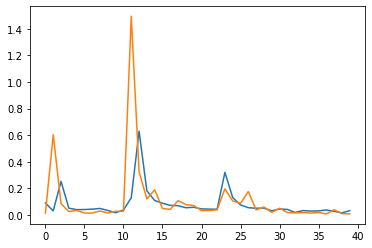

In [3]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])

plt.plot(history.history["val_loss"])